In [1]:
# Core
import os
import cv2
import numpy as np
import pandas as pd
import collections
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2026-01-03 18:28:28.507780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-03 18:28:29.085750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-03 18:28:39.323137: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mnt/d/tfgpu/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning:

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('pranavraikokte/covid19-image-dataset',unzip=True)

In [4]:
# Load Training Data (80%)
train_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(128, 128),
    seed=7
)

# Load Validation Data (20%)
val_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(128, 128),
    seed=7
)

# Load Test Data (separate folder)
test_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(128, 128),
    shuffle=False
)

Found 251 files belonging to 3 classes.
Using 201 files for training.


I0000 00:00:1767464925.510831  139567 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5590 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 251 files belonging to 3 classes.
Using 50 files for validation.
Found 66 files belonging to 3 classes.


In [5]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [6]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)


(32, 128, 128, 3)
(32,)


2026-01-03 18:28:47.126167: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2026-01-03 18:28:47.372087: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


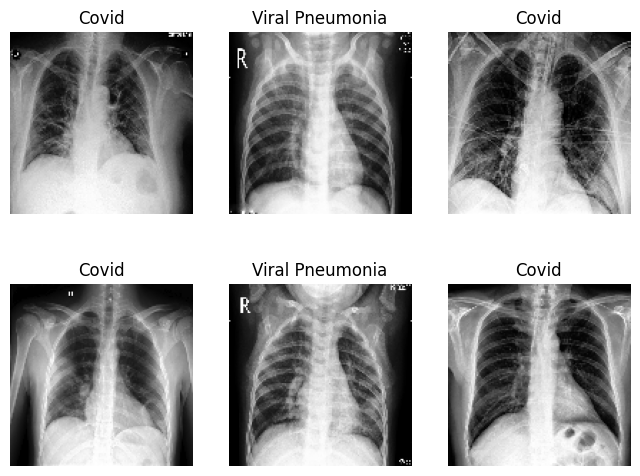

In [7]:
plt.figure(figsize=(8,6))
for images, labels in train_ds.take(1):
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


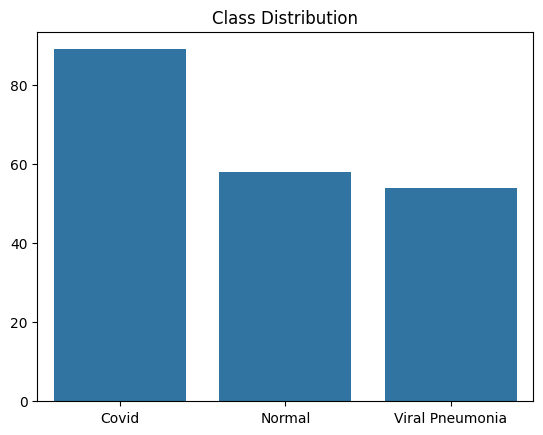

In [8]:
label_count = collections.Counter()

for _, labels in train_ds:
    label_count.update(labels.numpy())

sns.barplot(x=list(label_count.keys()),
            y=list(label_count.values()))
plt.xticks(range(len(class_names)), class_names)
plt.title("Class Distribution")
plt.show()

In [9]:
normalization_layer = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(
    lambda x, y: (normalization_layer(x), y)
)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)
val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y)
)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
model = keras.Sequential([
    # Input Layer (Explicit definition helps with debugging)
    layers.Input(shape=(128, 128, 3)),
    
    # Data Augmentation (Active only during training)
    data_augmentation,
    
    # Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Classification Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.time()

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1. Stop if model gets worse 
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# 2. Reduce Learning Rate if model stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      
    patience=10,      
    min_lr=0.00001   
)

# Train with both callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500, 
    callbacks=[early_stopping, reduce_lr] 
)

end_time = time.time()
total_time = end_time - start_time

print(f"Training time: {total_time:.2f} seconds")
print(f"Training time: {total_time/60:.2f} minutes")

Epoch 1/500


2026-01-03 18:28:52.039093: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.3532 - loss: 1.0951 - val_accuracy: 0.4400 - val_loss: 1.0876 - learning_rate: 1.0000e-04
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4378 - loss: 1.0893 - val_accuracy: 0.4400 - val_loss: 1.0822 - learning_rate: 1.0000e-04
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4478 - loss: 1.0792 - val_accuracy: 0.4400 - val_loss: 1.0785 - learning_rate: 1.0000e-04
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4229 - loss: 1.0818 - val_accuracy: 0.4400 - val_loss: 1.0767 - learning_rate: 1.0000e-04
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4428 - loss: 1.0746 - val_accuracy: 0.4400 - val_loss: 1.0746 - learning_rate: 1.0000e-04
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4229 - loss: 1.0911 - val_accuracy: 0.4400 - val_loss: 1.0730 - learning_rate: 1.0000e-04
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4279 - loss: 1.0820 - v

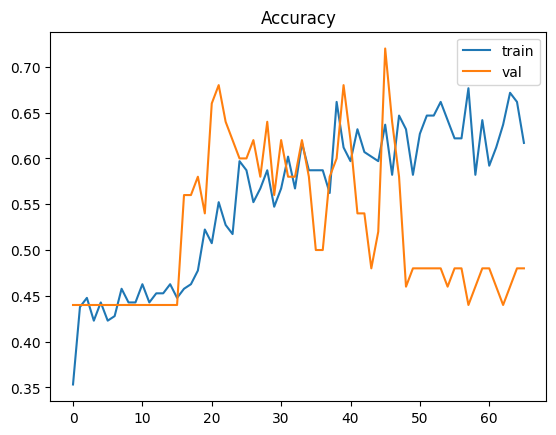

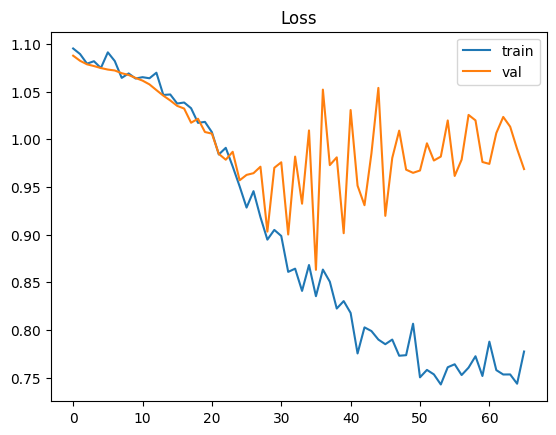

In [14]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


2026-01-03 18:29:04.342106: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


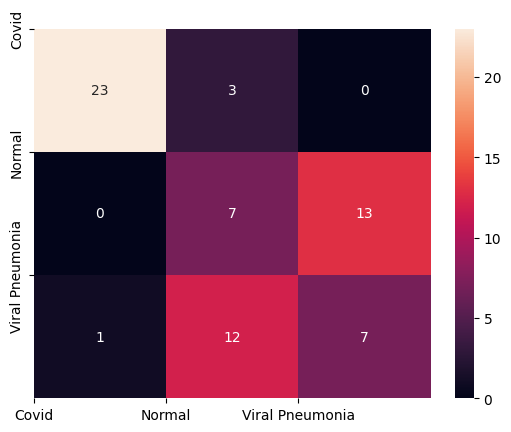

In [15]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d')
plt.xticks(range(3), class_names)
plt.yticks(range(3), class_names)
plt.show()


In [16]:
print(classification_report(
    y_true, y_pred,
    target_names=class_names
))

                 precision    recall  f1-score   support

          Covid       0.96      0.88      0.92        26
         Normal       0.32      0.35      0.33        20
Viral Pneumonia       0.35      0.35      0.35        20

       accuracy                           0.56        66
      macro avg       0.54      0.53      0.53        66
   weighted avg       0.58      0.56      0.57        66

